# Community 2: Protein Sequence Classification

**Disclaimer: This is uploaded from a github user, not the KAN authors. KAN authors did not writer this or proofread this carefully, hence are not responsible for mistakes in this notebook. If you have questions, please consult the github user who uploaded it. Thank you!**

In this example, we will see how to use KAN in protein sequence classification. We will be using one hot encoding to encode the amino acids.

#### This is just an example how it can be used for protein sequences. Need to use real data to actually observe the performance.

In [1]:
from kan import *
import torch
import random
import numpy as np

In [2]:
# Hyperparameters
PROTEIN_WINDOW_SIZE = 5 

# define the universe of possible input amino acids, ie. vocab list
aa_list = 'ARNDCQEGHILKMFPSTWYVX'

In [3]:
def one_hot_encode(protein_sequence):
    """
    One-hot encodes a protein sequence.

    Args:
        protein_sequence (str): The input protein sequence.

    Returns:
        numpy.array: The one-hot encoded representation of the protein sequence.
    """
    # Create a dictionary mapping amino acids to indices
    aa_to_index = {aa: i for i, aa in enumerate(aa_list)}
    
    # Initialize an array of zeros with shape (sequence_length, alphabet_length)
    encoding = np.zeros((len(protein_sequence), len(aa_list)))
    
    # Iterate over the protein sequence and set the corresponding index to 1
    for i, aa in enumerate(protein_sequence):
        if aa in aa_to_index:
            encoding[i, aa_to_index[aa]] = 1
        else:
            # If the amino acid is not in the alphabet, set the last index to 1 (unknown)
            encoding[i, -1] = 1
    
    return encoding

In [5]:
def generate_sample_protein_dataset(num_samples=20, protein_window_size=5):
    """
    Generate a dataset of protein sequences of length 11, keeping Lysine(K) in the center for label 1 and Serine(S) for label 0. 

    Args:
        num_samples (int): Number of samples to generate.
        protein_window_size (int): Length of the protein sequence.

    Returns:
        dict: A dictionary containing train_input, test_input, train_label, and test_label.
    """
    
    dataset = {'train_input': [], 'test_input': [], 'train_label': [], 'test_label': []}
    alphabet = 'ARNDCQEGHILKMFPSTWYVX'

    # Generate half of the samples with label 1 and half with label 0
    label_sequence = [1] * (num_samples // 2) + [0] * (num_samples // 2)
    random.shuffle(label_sequence)

    for label in label_sequence:
        # Generate a protein sequence with 'K' in the middle for label 1 and 'S' for label 0
        if label == 1:
            center_aa = 'K'
        else:
            center_aa = 'S'
        sequence = ''.join(random.choices(alphabet.replace(center_aa, ''), k=protein_window_size//2)) + center_aa + ''.join(random.choices(alphabet.replace(center_aa, ''), k=protein_window_size//2))
        print(sequence, label)
        encoded_sequence = one_hot_encode(sequence).flatten()

        # Split the dataset into train and test (50% each)
        if len(dataset['train_input']) < num_samples // 2:
            dataset['train_input'].append(encoded_sequence)
            dataset['train_label'].append(label)
        else:
            dataset['test_input'].append(encoded_sequence)
            dataset['test_label'].append(label)

    # Convert lists to tensors
    dataset['train_input'] = torch.tensor(dataset['train_input'])
    dataset['test_input'] = torch.tensor(dataset['test_input'])
    dataset['train_label'] = torch.tensor(dataset['train_label']).view(-1, 1)
    dataset['test_label'] = torch.tensor(dataset['test_label']).view(-1, 1)

    return dataset

# Generate dataset with 10 samples
dataset = generate_sample_protein_dataset(40)

GTKYX 1
TTKPP 1
AESVY 0
MYSFD 0
SQKNT 1
IDKAC 1
AXKTA 1
TESDW 0
YXSTF 0
VTSYF 0
HYKYE 1
RDSPA 0
MDSNK 0
SCKFH 1
AHKED 1
EFKYA 1
EPKLR 1
GWSRE 0
GMSYE 0
IPSKD 0
NSKQA 1
TWKNL 1
TCKFF 1
HNKSG 1
QNSKR 0
RVKYC 1
TESCP 0
SMKXE 1
IYSEV 0
XQSKD 0
VKSYN 0
EESGV 0
IISMQ 0
FLKGE 1
VMKGH 1
PTKMH 1
TLSIQ 0
TTSMA 0
ATKEE 1
MGSFT 0


In [6]:
print(dataset)

{'train_input': tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64), 'test_input': tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64), 'train_label': tensor([[1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0]]), 'test_label': tensor([[1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0

In [9]:
# define model
# create a KAN: 105 inputs, 2D output, and 3 hidden neurons. k=2, 3 grid intervals (grid=3).
# considering window size: 5, 5 times 21(vocab size), input-> 21 * 5

model = KAN(width=[105,3,2], grid=3, k=2)

In [10]:
def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).float())

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).float())

results = model.train(dataset, opt="LBFGS", steps=5, metrics=(train_acc, test_acc));
results['train_acc'][-1], results['test_acc'][-1]

train loss: 1.04e-03 | test loss: 2.33e-01 | reg: 6.38e+01 : 100%|████| 5/5 [00:15<00:00,  3.00s/it]


(1.0, 0.949999988079071)

In [11]:
lib = ['x','x^2']

model.auto_symbolic(lib=lib)

fixing (0,0,0) with x^2, r2=0.9999999665312771
fixing (0,0,1) with x^2, r2=0.9999979934036755
fixing (0,0,2) with x^2, r2=0.9999999622133074
fixing (0,1,0) with x^2, r2=0.9999999799949156
fixing (0,1,1) with x^2, r2=0.9991883825579457
fixing (0,1,2) with x^2, r2=0.9999994895376765
fixing (0,2,0) with x^2, r2=0.9999990593107048
fixing (0,2,1) with x^2, r2=0.9999996655563207
fixing (0,2,2) with x^2, r2=0.999999966951783
fixing (0,3,0) with x^2, r2=0.0
fixing (0,3,1) with x^2, r2=0.0
fixing (0,3,2) with x^2, r2=0.0
fixing (0,4,0) with x^2, r2=0.0
fixing (0,4,1) with x^2, r2=0.0
fixing (0,4,2) with x^2, r2=0.0
fixing (0,5,0) with x^2, r2=0.9999998808271742
fixing (0,5,1) with x^2, r2=0.9999998953621121
fixing (0,5,2) with x^2, r2=0.999999968375537
fixing (0,6,0) with x^2, r2=0.9981315108075913
fixing (0,6,1) with x^2, r2=0.999999843899342
fixing (0,6,2) with x^2, r2=0.9999999589830514
fixing (0,7,0) with x^2, r2=0.0
fixing (0,7,1) with x^2, r2=0.0
fixing (0,7,2) with x^2, r2=0.0
fixing (0,

In [12]:
formula1, formula2 = model.symbolic_formula()[0]
formula1

0.44*(0.02*(-x_1 - 1)**2 + 0.02*(x_10 + 1)**2 + 0.04*(-x_101 - 1)**2 + 0.01*(-x_13 - 1)**2 - 0.02*(-x_14 - 1)**2 - 0.02*(-x_15 - 1)**2 + 0.02*(-x_17 - 1)**2 + 0.03*(x_2 + 1)**2 - 0.e-2*(x_20 + 1)**2 - 0.e-2*(x_21 + 1)**2 - 0.03*(-x_24 - 1)**2 + 0.01*(-x_26 - 1)**2 - 0.02*(-x_29 - 1)**2 - 0.02*(-x_31 - 1)**2 + 0.01*(x_32 + 1)**2 + 0.01*(-x_33 - 1)**2 - 0.e-2*(x_37 + 1)**2 - 0.01*(-x_39 - 1)**2 - 0.e-2*(-x_40 - 1)**2 - 0.02*(-x_54 - 1)**2 + 0.02*(-x_58 - 1)**2 - 0.01*(-x_6 - 1)**2 - 0.01*(-x_66 - 1)**2 - 0.02*(-x_68 - 1)**2 + 0.02*(-x_69 - 1)**2 - 0.04*(x_70 + 1)**2 + 0.01*(-x_71 - 1)**2 + 0.03*(-x_73 - 1)**2 + 0.01*(-x_75 - 1)**2 + 0.01*(-x_76 - 1)**2 + 0.02*(-x_77 - 1)**2 - 0.01*(-x_82 - 1)**2 - 0.e-2*(-x_85 - 1)**2 - 0.02*(x_87 + 1)**2 - 0.e-2*(x_9 + 1)**2 - 0.04*(x_90 + 1)**2 + 0.03*(-x_91 - 1)**2 + 0.02*(x_93 + 1)**2 + 0.03*(x_98 + 1)**2 - 0.01*(-x_99 - 1)**2 - 1)**2 + 0.7*(-0.03*(-x_1 - 1)**2 - 0.02*(x_10 + 1)**2 + 0.02*(x_101 + 1)**2 - 0.03*(x_104 + 1)**2 + 0.05*(-x_13 - 1)**2 + 0

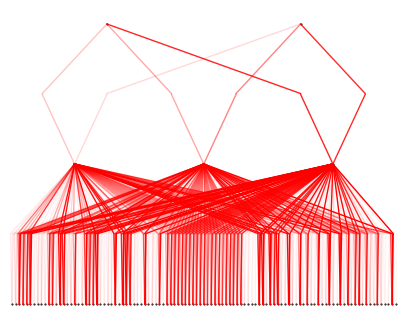

In [13]:
model.plot()